In [11]:
### 2024 JUL 20 ###

In [12]:
#options(warn=-1)
#options(dplyr.summarise.inform = FALSE)
#
#packages <- c("sp","rgdal","sf","rgeos","dplyr","plyr","ggplot2","raster","mapview","stringr",
#              "maptools","gridExtra","lattice","MASS","foreach","optmatch","doParallel",
#              "rlang","tidyr","magrittr","viridis","ggmap","spatialEco","bit64",
#              "randomForest","modelr","geojsonio","rgeos") #"hrbrthemes","RItools","Hmisc",
#package.check <- lapply(packages, FUN = function(x) {
#    suppressPackageStartupMessages(library(x, character.only = TRUE))
#})


In [1]:
library("terra")
library("dplyr")
library("sf")
library("sp")

terra 1.7.29


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE



In [1]:
#conda install -c conda-forge r-s3
install.packages("s3")
library("s3")
#library("aws.s3")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# args = commandArgs(trailingOnly=TRUE)
# if (length(args)==0) {
#   stop("At least one argument must be supplied (input file).n", call.=FALSE)
# } else if (length(args)>=1) {
#  
#   iso3 <- args[1]  #country to process
#   gediwk <- args[2]   #the # of weeks GEDI data to use
#   mproc <- as.integer(args[3])#the number of cores to use for macthing 
# }

In [3]:
#To test, we define the variables manually. For final version, run the commented out section below
gediwk <- 24
iso3 <-"Bpp"

In [4]:
cat("Step 0: Loading global variables for", iso3, "with wk", gediwk, "data \n")

Step 0: Loading global variables for Bpp with wk 24 data 


In [5]:
#f.path <- "/projects/my-public-bucket/GEDI_global_PA_v2/"
f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"

matching_tifs <- c("wwf_biomes","wwf_ecoreg","lc2000","d2roads", "dcities","dem",
                   "pop_cnt_2000","pop_den_2000","slope", "tt2cities_2000", "wc_prec_1990-1999",
                   "wc_tmax_1990-1999","wc_tavg_1990-1999","wc_tmin_1990-1999" )


In [6]:
ecoreg_key <- read.csv(s3_get(paste(f.path,"wwf_ecoregions_key.csv",sep="")))
#unlink(s3_get(paste(f.path,"wwf_ecoregions_key.csv",sep="")))

allPAs <- readRDS(s3_get(paste(f.path,"WDPA_shapefiles/WDPA_polygons/",iso3,"_PA_poly.rds",sep="")))

MCD12Q1 <- rast(s3_get(paste(f.path,"GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif",sep="")))
#projection(MCD12Q1) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
crs(MCD12Q1)  <- "epsg:6933"

world_region <- rast(s3_get(paste(f.path,"GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif",sep="")))
#projection(world_region) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
crs(world_region)  <- "epsg:6933"

#s3_get_files(c(paste(f.path,"WDPA_countries/shp/",iso3,".shp",sep=""),
#              paste(f.path,"WDPA_countries/shp/",iso3,".shx",sep=""),
#              paste(f.path,"WDPA_countries/shp/",iso3,".prj",sep=""),
#              paste(f.path,"WDPA_countries/shp/",iso3,".dbf",sep="")),confirm = FALSE)
#adm <- st_read(s3_get(paste(f.path,"WDPA_countries/shp/",iso3,".shp",sep="")))

s3_path <- paste("/vsis3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_countries/shp/",iso3,".shp",sep="") #Redo this for the gpkg
adm <- st_read(s3_path)
adm_prj <- project(vect(adm), "epsg:6933")

load(s3_get(paste(f.path,"rf_noclimate.RData",sep="")))
#source(s3_get(paste(f.path,"matching_func.R",sep="")))
#source(s3_get(paste(f.path,"matching_func_2024.R",sep="")))


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/wwf_ecoregions_key.csv already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/wwf_ecoregions_key.csv

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/Bpp_PA_poly.rds already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/Bpp_PA_poly.rds



ERROR: Error in rast(s3_get(paste(f.path, "GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif", : could not find function "rast"


In [21]:
# STEP1. Create 1km sampling grid with points only where GEDI data is available; first check if grid file exist to avoid reprocessing 
#if(!file.exists(paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))){
  cat("Step 1: Creating 1km sampling grid filter GEDI data for", iso3,"\n")
  GRID.lats <- rast(s3_get(paste(f.path,"EASE2_M01km_lats.tif", sep="")))
  GRID.lons <- rast(s3_get(paste(f.path,"EASE2_M01km_lons.tif", sep="")))
  GRID.lats.adm   <- crop(GRID.lats, adm_prj)
  GRID.lats.adm.m <- mask(GRID.lats.adm, adm_prj)
  GRID.lons.adm   <- crop(GRID.lons, adm_prj)
  GRID.lons.adm.m <- mask(GRID.lons.adm, adm_prj)
  rm(GRID.lats, GRID.lons, GRID.lats.adm, GRID.lons.adm)
  
  #1.3) extract coordinates of raster cells with valid GEDI data in them
  #gedi_folder <- paste(f.path,"WDPA_gedi_l2a+l2b_clean2/",iso3,"/",sep="")
  gedi_folder <- paste(f.path,"WDPA_gedi_L4A_tiles/",sep="")
  #iso3_tiles <- paste("/projects/my-public-bucket/AOIs/vero_1deg_tiles_",iso3,"/",sep="")
  #tileindex_df <- read.csv(paste("/projects/my-public-bucket/AOIs/vero_1deg_tileindex/tileindex_",iso3,".csv", sep=""))
  tileindex_df <- read.csv(s3_get(paste(f.path,"vero_1deg_tileindex/tileindex_",iso3,".csv", sep="")))
  iso3_tiles <- tileindex_df$tileindexiso3_tiles <- tileindex_df$tileindex
    
  GRID.coords <- data.frame()
  #for(i in 1:length(dir(gedi_folder))){
  #for(i in 1:length(dir(iso3_tiles))){
  for(i in 1:length(iso3_tiles)){
    # print(list.files(gedi_folder)[i])
    
    iso3_tile_in <- paste("tile_num_",iso3_tiles[i],sep="")
    
    #if(!file.exists(paste(gedi_folder,iso3_tile_in,"_L4A.gpkg",sep=""))){
    #    print(paste(iso3_tile_in," does not exist",sep=""))
    #    } else {
    print(paste(iso3_tile_in," processing",sep=""))
    #gedi_data <- read.csv(list.files(gedi_folder,full.names=TRUE)[i]) %>%
    gedi_data <- read_sf(s3_get(paste(gedi_folder,iso3_tile_in,"_L4A.gpkg",sep="")), int64_as_string = TRUE) %>%
      dplyr::select(lon_lowestmode,lat_lowestmode)
    gedi_data <- gedi_data %>% st_drop_geometry()
#    gedi_pts  <- SpatialPoints(coords=gedi_data[,c("lon_lowestmode","lat_lowestmode")],
#                               proj4string=CRS("+init=epsg:4326"))
#    gedi_pts_prj <- spTransform(gedi_pts, "+init=epsg:6933")
    gedi_pts  <- vect(gedi_data, geom=c("lon_lowestmode","lat_lowestmode"), crs="epsg:4326", keepgeom=FALSE)        
    gedi_pts_prj <- project(gedi_pts, "epsg:6933")
        
    gcount_ras <- rasterize(geom(gedi_pts_prj)[,c("x","y")], GRID.lons.adm.m, fun="count", background=NA)
    names(gcount_ras) <- "gshot_counts"
    #pxid <- raster::extract(gcount_ras,  gedi_pts_prj)
    pxid <- extract(gcount_ras, gedi_pts_prj)
    #gedi_pts_prj_sp <- gedi_pts_prj %>% SpatialPointsDataFrame(., data=data.frame(pxid))
    gedi_pts_prj$pxid <- pxid[,"gshot_counts"]
    gedi_pts_prj_sp <- gedi_pts_prj    
    gedi_pts_prj_sp$pxid[is.na(gedi_pts_prj_sp$pxid)] <- 0
    gedi_pts_prj_filtered <- gedi_pts_prj_sp[gedi_pts_prj_sp$pxid >= 1,]  #change the numeric threshold to filter with a different min # of GEDI shots in each 1km cell
    
    GRID.lons.overlap <- GRID.lons.adm.m[gedi_pts_prj_filtered]
    GRID.lats.overlap <- GRID.lats.adm.m[gedi_pts_prj_filtered]
    
    x.overlap <- GRID.lons.overlap[!is.na(GRID.lons.overlap)]
    y.overlap <- GRID.lats.overlap[!is.na(GRID.lats.overlap)]
    
    xy.overlap <- cbind(x.overlap,y.overlap)
    xy.overlap.clean <- unique(xy.overlap)
    
    GRID.coords <- rbind(GRID.coords, xy.overlap.clean)
    #}
  }
  #GRID.for.matching <- SpatialPoints(coords = GRID.coords, proj4string=CRS("+init=epsg:4326"))
  GRID.for.matching <- vect(GRID.coords, geom=c("x.overlap","y.overlap"), crs = "epsg:4326")
  #saveRDS(GRID.for.matching, file = paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))
saveRDS(GRID.for.matching, file = paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))
#} else if (file.exists(paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))) {
#  cat(paste("STEP 1: Grid file exists, no need to process grids for ",iso3, "\n"))
#}


Step 1: Creating 1km sampling grid filter GEDI data for Bpp 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/EASE2_M01km_lats.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/EASE2_M01km_lats.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/EASE2_M01km_lons.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/EASE2_M01km_lons.tif



[1] "tile_num_22080 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22080_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22080_L4A.gpkg



[1] "tile_num_22081 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22081_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22081_L4A.gpkg



[1] "tile_num_22259 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22259_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22259_L4A.gpkg



[1] "tile_num_22260 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22260_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22260_L4A.gpkg



[1] "tile_num_22261 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22261_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22261_L4A.gpkg



[1] "tile_num_22262 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22262_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22262_L4A.gpkg



[1] "tile_num_22439 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22439_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22439_L4A.gpkg



[1] "tile_num_22440 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22440_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22440_L4A.gpkg



[1] "tile_num_22441 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22441_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22441_L4A.gpkg



[1] "tile_num_22442 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22442_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22442_L4A.gpkg



[1] "tile_num_22619 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22619_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22619_L4A.gpkg



[1] "tile_num_22620 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22620_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22620_L4A.gpkg



[1] "tile_num_22621 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22621_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22621_L4A.gpkg



[1] "tile_num_22622 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22622_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22622_L4A.gpkg



[1] "tile_num_22799 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22799_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22799_L4A.gpkg



[1] "tile_num_22800 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22800_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22800_L4A.gpkg



[1] "tile_num_22801 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22801_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22801_L4A.gpkg



[1] "tile_num_22802 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22802_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22802_L4A.gpkg



[1] "tile_num_22803 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22803_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22803_L4A.gpkg



[1] "tile_num_22804 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22804_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22804_L4A.gpkg



[1] "tile_num_22980 processing"
[1] "tile_num_22981 processing"
[1] "tile_num_22982 processing"
[1] "tile_num_22983 processing"
[1] "tile_num_22984 processing"
[1] "tile_num_23160 processing"
[1] "tile_num_23161 processing"
[1] "tile_num_23162 processing"
[1] "tile_num_23163 processing"
[1] "tile_num_23340 processing"
[1] "tile_num_23341 processing"
[1] "tile_num_23342 processing"
[1] "tile_num_23520 processing"


In [22]:
# STEP2. Clip sampling grid to nonPA areas within country & sample raster layers on nonPA grid
cat("Step 2.0: Reading 1k GRID from RDS for " ,iso3, "\n")
#GRID.for.matching <- readRDS(s3_get(paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))) 
#GRID.for.matching <- vect(GRID.for.matching)
GRID.for.matching

Step 2.0: Reading 1k GRID from RDS for  Bpp 


 class       : SpatVector 
 geometry    : points 
 dimensions  : 179490, 0  (geometries, attributes)
 extent      : -57.64004, -49.7251, -33.74662, -28.08536  (xmin, xmax, ymin, ymax)
 coord. ref. : lon/lat WGS 84 (EPSG:4326) 

In [23]:
#if(!file.exists(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep=""))){
#  if(!dir.exists(paste(f.path,"WDPA_matching_points/",iso3,"/",sep=""))){
#      dir.create(paste(f.path,"WDPA_matching_points/",iso3,"/",sep=""))}    
  cat("Step 2.1: Preparing control dataset for", iso3, "\n")
  #GRID.pts.nonPA <- GRID.for.matching %>% spTransform(., "+init=epsg:4326")
  GRID.pts.nonPA <- project(GRID.for.matching, "epsg:4326")
  for(i in 1:length(allPAs)){
    PA          <- vect(allPAs[i,])
    PA_prj      <- project(PA, "epsg:6933")
    #PA_prj_buff <- gBuffer(PA_prj, width = 10000) #10km buffer
    PA_prj_buff <- buffer(PA_prj, width = 10000)
    PA2         <- project(PA_prj_buff, "epsg:4326")
    overlap     <- GRID.pts.nonPA[PA2]
    if(length(overlap)>0){
      GRID.pts.nonPA0 <- st_difference(sf::st_as_sf(GRID.pts.nonPA), sf::st_as_sf(PA2)) ##remove pts inside poly
      #GRID.pts.nonPA <- as(GRID.pts.nonPA0$geometry,'Spatial') %>% spTransform(., "+init=epsg:4326")
      GRID.pts.nonPA <- vect(GRID.pts.nonPA0$geometry)
      GRID.pts.nonPA <- project(GRID.pts.nonPA, "epsg:4326")
    } 
    # print(length(GRID.pts.nonPA))
  }
  nonPA_xy  <- geom(GRID.pts.nonPA)[,c("x","y")]
  colnames(nonPA_xy)  <- c("x","y")
  #nonPA_spdf  <- tryCatch(SpatialPointsDataFrame(nonPA_xy, data=data.frame(nonPA_xy),proj4string=CRS("+init=epsg:4326")),
  nonPA_spdf  <- tryCatch(vect(nonPA_xy, crs="epsg:4326"),      
                          error=function(cond){
                            cat("Country too samll, after buffer no grid left, so quit processing country", iso3, dim(nonPA_xy),"\n")
                            #writeLines("Country too samll, after buffer no grid left", paste(f.path,"WDPA_log/",iso3,"_log_control.txt", sep=""))
                            return(quit(save="no"))})
    
    
  for (j in 1:length(matching_tifs)){
    #ras <- raster(paste(f.path, "WDPA_input_vars_iso3/",iso3,"/",matching_tifs[j],".tif", sep=""))
    ras <- rast(s3_get(paste(f.path, "WDPA_input_vars_GLOBAL/",matching_tifs[j],".tif", sep="")))
    print(matching_tifs[j])
    ras_ex <- extract(ras, nonPA_spdf, method="simple", factors=FALSE)
    nm <- names(ras)
    #nonPA_spdf <- cbind(nonPA_spdf, ras_ex[,matching_tifs[j]])
    #names(nonPA_spdf)[j+2] <- matching_tifs[j]
    nonPA_spdf$nm <- ras_ex[, matching_tifs[j]]
    names(nonPA_spdf)[j] <- matching_tifs[j]
  }
  nonPA_spdf$x <- geom(nonPA_spdf)[,"x"]
  nonPA_spdf$y <- geom(nonPA_spdf)[,"y"]
  
  d_control <- nonPA_spdf
  d_control$status <- as.logical("FALSE")
  names(d_control) <- make.names(names(d_control), allow_ = FALSE)
  d_control <- data.frame(d_control) %>%
    dplyr::rename(
      land_cover = lc2000,
      slope = slope,
      elevation = dem,
      popden = pop.den.2000,
      popcnt=pop.cnt.2000,
      min_temp=wc.tmin.1990.1999,
      max_temp=wc.tmax.1990.1999,
      mean_temp = wc.tavg.1990.1999,
      prec = wc.prec.1990.1999,
      tt2city= tt2cities.2000,
      wwfbiom = wwf.biomes,
      wwfecoreg = wwf.ecoreg,
      d2city = dcities,
      d2road = d2roads,
      lon = x,
      lat = y)
  d_control$land_cover <- factor(d_control$land_cover, levels=sequence(7),
                                 labels = c("l1_forest",
                                            "l2_grassland",
                                            "l3_agriculture",
                                            "l4_wetlands",
                                            "l5_artificial",
                                            "l6_other land/bare",
                                            "l7_water"))
  d_control$wwfbiom <- factor(d_control$wwfbiom,
                           levels = as.vector(unique(ecoreg_key[,"BIOME"])),
                           labels = as.vector(unique(ecoreg_key[,"BIOME_NAME"])))
  d_control$wwfecoreg <- factor(d_control$wwfecoreg,
                             levels = as.vector(ecoreg_key[,"ECO_ID"]),
                             labels = as.vector(ecoreg_key[,"ECO_NAME"]))
  
  
  d_control$UID <-  seq.int(nrow(d_control))
  
  #saveRDS(d_control, file=paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep="")) 
  saveRDS(d_control, file=paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep="")) 
#  filename_out <- paste(iso3,"_prepped_control_wk",gediwk,".RDS", sep="")
#  saveRDS(d_control, file = filename_out)  
  
#} else if (file.exists(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep=""))){
#  cat("Step 2.1: preppred control dataset already exists for", iso3, "no need for reprocessing\n")
#}


Step 2.1: Preparing control dataset for Bpp 


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant through

[1] "wwf_biomes"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif



[1] "wwf_ecoreg"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif



[1] "lc2000"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif



[1] "d2roads"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/dcities.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/dcities.tif



[1] "dcities"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/dem.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/dem.tif



[1] "dem"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/pop_cnt_2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/pop_cnt_2000.tif



[1] "pop_cnt_2000"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/pop_den_2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/pop_den_2000.tif



[1] "pop_den_2000"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/slope.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/slope.tif



[1] "slope"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/tt2cities_2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/tt2cities_2000.tif



[1] "tt2cities_2000"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_prec_1990-1999.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_prec_1990-1999.tif



[1] "wc_prec_1990-1999"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tmax_1990-1999.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tmax_1990-1999.tif



[1] "wc_tmax_1990-1999"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tavg_1990-1999.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tavg_1990-1999.tif



[1] "wc_tavg_1990-1999"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tmin_1990-1999.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tmin_1990-1999.tif



[1] "wc_tmin_1990-1999"


Warning message in gzfile(file, mode):
“cannot open compressed file '/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/Bpp/Bpp_prepped_control_wk24.RDS', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, mode): cannot open the connection


In [24]:
dir.create(paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/",iso3,sep=""))
dir.create(paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/",iso3,
                 "/",iso3,"_testPAs",sep=""))

In [25]:
saveRDS(d_control, file=paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep="")) 

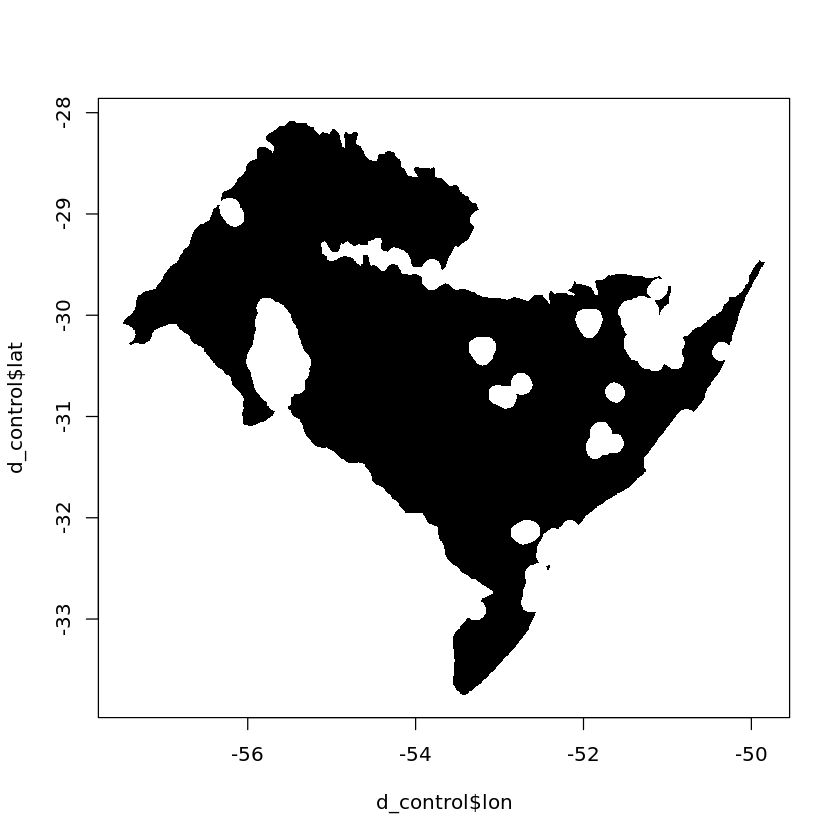

In [26]:
plot(d_control$lon, d_control$lat, pch=".")

In [27]:
#STEP3. Loop through all PAs in iso3 country:
# - clip sampling grid to each PA
# - sample raster layers on each PA grid
# - save each PA sample into prepped_pa_##.RDS file

cat("Step 3.0: Reading 1k GRID from RDS for " ,iso3, "\n")
#GRID.for.matching <- readRDS(s3_get(paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))) 
#GRID.for.matching <- vect(GRID.for.matching)
GRID.for.matching

Step 3.0: Reading 1k GRID from RDS for  Bpp 


 class       : SpatVector 
 geometry    : points 
 dimensions  : 179490, 0  (geometries, attributes)
 extent      : -57.64004, -49.7251, -33.74662, -28.08536  (xmin, xmax, ymin, ymax)
 coord. ref. : lon/lat WGS 84 (EPSG:4326) 

In [28]:
#if(length(dir(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",sep=""),pattern = paste(gediwk,".RDS",sep="")))==0){
#  if(!dir.exists(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",sep=""))){
#      dir.create(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",sep=""))}
  cat("Step 3.1: Processing prepped PA treatment dataset for ", iso3, "\n")

testPAs_fileindex <- cbind(allPAs$WDPAID, rep(NA, nrow(allPAs)))
colnames(testPAs_fileindex) <- c("WDPAID", "filename")

  for(i in 1:length(allPAs)){
    cat(iso3, i, "out of ", length(allPAs), "\n")
    testPA <- vect(allPAs[i,])
    testPA <- project(testPA, "epsg:4326")
    GRID.pts.testPA <- GRID.for.matching[testPA]

    #if(length(GRID.pts.testPA)>0){
    if(length(GRID.pts.testPA)>1){
      #testPA_xy <- coordinates(GRID.pts.testPA)
      testPA_xy <- geom(GRID.pts.testPA)[,c("x","y")]
      colnames(testPA_xy) <- c("x","y")
      #testPA_spdf <- SpatialPointsDataFrame(testPA_xy, data=data.frame(testPA_xy), proj4string=CRS("+init=epsg:4326"))
      testPA_spdf  <- vect(testPA_xy, crs="epsg:4326")
                              
        for (j in 1:length(matching_tifs)){
        #ras <- raster(paste(f.path, "WDPA_input_vars_iso3/",iso3,"/",matching_tifs[j],".tif", sep=""))
        ras <- rast(s3_get(paste(f.path, "WDPA_input_vars_GLOBAL/",matching_tifs[j],".tif", sep="")))
        ras <- crop(ras, testPA)
        ras_ex <- extract(ras, testPA_spdf, method="simple", factors=F)
        nm <- names(ras)
        #testPA_spdf <- cbind(testPA_spdf, ras_ex[,matching_tifs[j]])
        #names(testPA_spdf)[j+2] <- matching_tifs[j]
        testPA_spdf$nm <- ras_ex[, matching_tifs[j]]
        names(testPA_spdf)[j] <- matching_tifs[j]
  }
    testPA_spdf$x <- geom(testPA_spdf)[,"x"]
    testPA_spdf$y <- geom(testPA_spdf)[,"y"]
      
      d_pa <- testPA_spdf
      d_pa$status <- as.logical("TRUE")
      d_pa$DESIG_ENG <- testPA$DESIG_ENG
      d_pa$REP_AREA <- testPA$REP_AREA
      d_pa$PA_STATUS <- testPA$STATUS
      d_pa$PA_STATUSYR <- testPA$STATUS_YR
      d_pa$GOV_TYPE <- testPA$GOV_TYPE
      d_pa$OWN_TYPE <- testPA$OWN_TYPE
      d_pa$MANG_AUTH <- testPA$MANG_AUTH
      names(d_pa) <- make.names(names(d_pa), allow_ = FALSE)
      d_pa <- data.frame(d_pa) %>%
        dplyr::rename(
          land_cover = lc2000,
          slope = slope,
          elevation = dem,
          popden = pop.den.2000,
          popcnt=pop.cnt.2000,
          min_temp=wc.tmin.1990.1999,
          max_temp=wc.tmax.1990.1999,
          mean_temp = wc.tavg.1990.1999,
          prec = wc.prec.1990.1999,
          tt2city= tt2cities.2000,
          wwfbiom = wwf.biomes,
          wwfecoreg = wwf.ecoreg,
          d2city = dcities,
          d2road = d2roads,
          lon = x,
          lat = y)
      d_pa$land_cover <- factor(d_pa$land_cover, levels=sequence(7),
                                labels = c("l1_forest",
                                           "l2_grassland",
                                           "l3_agriculture",
                                           "l4_wetlands",
                                           "l5_artificial",
                                           "l6_other land/bare",
                                           "l7_water"))
      d_pa$wwfbiom <- factor(d_pa$wwfbiom,
                          levels = as.vector(unique(ecoreg_key[,"BIOME"])),
                          labels = as.vector(unique(ecoreg_key[,"BIOME_NAME"])))
      d_pa$wwfecoreg <- factor(d_pa$wwfecoreg,
                            levels = as.vector(ecoreg_key[,"ECO_ID"]),
                            labels = as.vector(ecoreg_key[,"ECO_NAME"]))
      
      d_pa$UID <- seq.int(nrow(d_pa))
      #saveRDS(d_pa, file = paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/","prepped_pa_",
      #                           testPA$WDPAID,"_wk",gediwk,".RDS", sep=""))
      saveRDS(d_pa, file = paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",iso3,"_prepped_pa_",
                                 testPA$WDPAID,"_wk",gediwk,".RDS", sep=""))
    
    testPAs_fileindex[i,"filename"] <- paste(iso3,"_prepped_pa_",testPA$WDPAID,"_wk",gediwk,".RDS", sep="")    

    #filename_out <- paste("prepped_pa_",testPA$WDPAID,"_wk",gediwk,".RDS", sep="")
    #saveRDS(d_pa, file = filename_out)  

    }
  }

write.csv(testPAs_fileindex, file = paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/",iso3,"/",iso3,"_testPAs_fileindex.csv", sep=""), row.names=F)

#} else if (length(dir(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",sep=""),pattern = paste(gediwk,".RDS",sep="")))==length(allPAs)){
#  cat("Step 3.1: prepped PA treatment dataset already exists for ", iso3, "no need for reprocessing\n")
#}


Step 3.1: Processing prepped PA treatment dataset for  Bpp 
Bpp 1 out of  2521 
Bpp 2 out of  2521 
Bpp 3 out of  2521 
Bpp 4 out of  2521 
Bpp 5 out of  2521 
Bpp 6 out of  2521 
Bpp 7 out of  2521 
Bpp 8 out of  2521 
Bpp 9 out of  2521 
Bpp 10 out of  2521 
Bpp 11 out of  2521 
Bpp 12 out of  2521 
Bpp 13 out of  2521 
Bpp 14 out of  2521 
Bpp 15 out of  2521 
Bpp 16 out of  2521 
Bpp 17 out of  2521 
Bpp 18 out of  2521 
Bpp 19 out of  2521 
Bpp 20 out of  2521 
Bpp 21 out of  2521 
Bpp 22 out of  2521 
Bpp 23 out of  2521 
Bpp 24 out of  2521 
Bpp 25 out of  2521 
Bpp 26 out of  2521 
Bpp 27 out of  2521 
Bpp 28 out of  2521 
Bpp 29 out of  2521 
Bpp 30 out of  2521 
Bpp 31 out of  2521 
Bpp 32 out of  2521 
Bpp 33 out of  2521 
Bpp 34 out of  2521 
Bpp 35 out of  2521 
Bpp 36 out of  2521 
Bpp 37 out of  2521 
Bpp 38 out of  2521 
Bpp 39 out of  2521 
Bpp 40 out of  2521 
Bpp 41 out of  2521 
Bpp 42 out of  2521 
Bpp 43 out of  2521 
Bpp 44 out of  2521 
Bpp 45 out of  2521 
Bpp 

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 64 out of  2521 
Bpp 65 out of  2521 
Bpp 66 out of  2521 
Bpp 67 out of  2521 
Bpp 68 out of  2521 
Bpp 69 out of  2521 
Bpp 70 out of  2521 
Bpp 71 out of  2521 
Bpp 72 out of  2521 
Bpp 73 out of  2521 
Bpp 74 out of  2521 
Bpp 75 out of  2521 
Bpp 76 out of  2521 
Bpp 77 out of  2521 
Bpp 78 out of  2521 
Bpp 79 out of  2521 
Bpp 80 out of  2521 
Bpp 81 out of  2521 
Bpp 82 out of  2521 
Bpp 83 out of  2521 
Bpp 84 out of  2521 
Bpp 85 out of  2521 
Bpp 86 out of  2521 
Bpp 87 out of  2521 
Bpp 88 out of  2521 
Bpp 89 out of  2521 
Bpp 90 out of  2521 
Bpp 91 out of  2521 
Bpp 92 out of  2521 
Bpp 93 out of  2521 
Bpp 94 out of  2521 
Bpp 95 out of  2521 
Bpp 96 out of  2521 
Bpp 97 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 98 out of  2521 
Bpp 99 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 100 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 101 out of  2521 
Bpp 102 out of  2521 
Bpp 103 out of  2521 
Bpp 104 out of  2521 
Bpp 105 out of  2521 
Bpp 106 out of  2521 
Bpp 107 out of  2521 
Bpp 108 out of  2521 
Bpp 109 out of  2521 
Bpp 110 out of  2521 
Bpp 111 out of  2521 
Bpp 112 out of  2521 
Bpp 113 out of  2521 
Bpp 114 out of  2521 
Bpp 115 out of  2521 
Bpp 116 out of  2521 
Bpp 117 out of  2521 
Bpp 118 out of  2521 
Bpp 119 out of  2521 
Bpp 120 out of  2521 
Bpp 121 out of  2521 
Bpp 122 out of  2521 
Bpp 123 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 124 out of  2521 
Bpp 125 out of  2521 
Bpp 126 out of  2521 
Bpp 127 out of  2521 
Bpp 128 out of  2521 
Bpp 129 out of  2521 
Bpp 130 out of  2521 
Bpp 131 out of  2521 
Bpp 132 out of  2521 
Bpp 133 out of  2521 
Bpp 134 out of  2521 
Bpp 135 out of  2521 
Bpp 136 out of  2521 
Bpp 137 out of  2521 
Bpp 138 out of  2521 
Bpp 139 out of  2521 
Bpp 140 out of  2521 
Bpp 141 out of  2521 
Bpp 142 out of  2521 
Bpp 143 out of  2521 
Bpp 144 out of  2521 
Bpp 145 out of  2521 
Bpp 146 out of  2521 
Bpp 147 out of  2521 
Bpp 148 out of  2521 
Bpp 149 out of  2521 
Bpp 150 out of  2521 
Bpp 151 out of  2521 
Bpp 152 out of  2521 
Bpp 153 out of  2521 
Bpp 154 out of  2521 
Bpp 155 out of  2521 
Bpp 156 out of  2521 
Bpp 157 out of  2521 
Bpp 158 out of  2521 
Bpp 159 out of  2521 
Bpp 160 out of  2521 
Bpp 161 out of  2521 
Bpp 162 out of  2521 
Bpp 163 out of  2521 
Bpp 164 out of  2521 
Bpp 165 out of  2521 
Bpp 166 out of  2521 
Bpp 167 out of  2521 
Bpp 168 out of  2521 
Bpp 169 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 183 out of  2521 
Bpp 184 out of  2521 
Bpp 185 out of  2521 
Bpp 186 out of  2521 
Bpp 187 out of  2521 
Bpp 188 out of  2521 
Bpp 189 out of  2521 
Bpp 190 out of  2521 
Bpp 191 out of  2521 
Bpp 192 out of  2521 
Bpp 193 out of  2521 
Bpp 194 out of  2521 
Bpp 195 out of  2521 
Bpp 196 out of  2521 
Bpp 197 out of  2521 
Bpp 198 out of  2521 
Bpp 199 out of  2521 
Bpp 200 out of  2521 
Bpp 201 out of  2521 
Bpp 202 out of  2521 
Bpp 203 out of  2521 
Bpp 204 out of  2521 
Bpp 205 out of  2521 
Bpp 206 out of  2521 
Bpp 207 out of  2521 
Bpp 208 out of  2521 
Bpp 209 out of  2521 
Bpp 210 out of  2521 
Bpp 211 out of  2521 
Bpp 212 out of  2521 
Bpp 213 out of  2521 
Bpp 214 out of  2521 
Bpp 215 out of  2521 
Bpp 216 out of  2521 
Bpp 217 out of  2521 
Bpp 218 out of  2521 
Bpp 219 out of  2521 
Bpp 220 out of  2521 
Bpp 221 out of  2521 
Bpp 222 out of  2521 
Bpp 223 out of  2521 
Bpp 224 out of  2521 
Bpp 225 out of  2521 
Bpp 226 out of  2521 
Bpp 227 out of  2521 
Bpp 228 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 408 out of  2521 
Bpp 409 out of  2521 
Bpp 410 out of  2521 
Bpp 411 out of  2521 
Bpp 412 out of  2521 
Bpp 413 out of  2521 
Bpp 414 out of  2521 
Bpp 415 out of  2521 
Bpp 416 out of  2521 
Bpp 417 out of  2521 
Bpp 418 out of  2521 
Bpp 419 out of  2521 
Bpp 420 out of  2521 
Bpp 421 out of  2521 
Bpp 422 out of  2521 
Bpp 423 out of  2521 
Bpp 424 out of  2521 
Bpp 425 out of  2521 
Bpp 426 out of  2521 
Bpp 427 out of  2521 
Bpp 428 out of  2521 
Bpp 429 out of  2521 
Bpp 430 out of  2521 
Bpp 431 out of  2521 
Bpp 432 out of  2521 
Bpp 433 out of  2521 
Bpp 434 out of  2521 
Bpp 435 out of  2521 
Bpp 436 out of  2521 
Bpp 437 out of  2521 
Bpp 438 out of  2521 
Bpp 439 out of  2521 
Bpp 440 out of  2521 
Bpp 441 out of  2521 
Bpp 442 out of  2521 
Bpp 443 out of  2521 
Bpp 444 out of  2521 
Bpp 445 out of  2521 
Bpp 446 out of  2521 
Bpp 447 out of  2521 
Bpp 448 out of  2521 
Bpp 449 out of  2521 
Bpp 450 out of  2521 
Bpp 451 out of  2521 
Bpp 452 out of  2521 
Bpp 453 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 738 out of  2521 
Bpp 739 out of  2521 
Bpp 740 out of  2521 
Bpp 741 out of  2521 
Bpp 742 out of  2521 
Bpp 743 out of  2521 
Bpp 744 out of  2521 
Bpp 745 out of  2521 
Bpp 746 out of  2521 
Bpp 747 out of  2521 
Bpp 748 out of  2521 
Bpp 749 out of  2521 
Bpp 750 out of  2521 
Bpp 751 out of  2521 
Bpp 752 out of  2521 
Bpp 753 out of  2521 
Bpp 754 out of  2521 
Bpp 755 out of  2521 
Bpp 756 out of  2521 
Bpp 757 out of  2521 
Bpp 758 out of  2521 
Bpp 759 out of  2521 
Bpp 760 out of  2521 
Bpp 761 out of  2521 
Bpp 762 out of  2521 
Bpp 763 out of  2521 
Bpp 764 out of  2521 
Bpp 765 out of  2521 
Bpp 766 out of  2521 
Bpp 767 out of  2521 
Bpp 768 out of  2521 
Bpp 769 out of  2521 
Bpp 770 out of  2521 
Bpp 771 out of  2521 
Bpp 772 out of  2521 
Bpp 773 out of  2521 
Bpp 774 out of  2521 
Bpp 775 out of  2521 
Bpp 776 out of  2521 
Bpp 777 out of  2521 
Bpp 778 out of  2521 
Bpp 779 out of  2521 
Bpp 780 out of  2521 
Bpp 781 out of  2521 
Bpp 782 out of  2521 
Bpp 783 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1123 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1124 out of  2521 
Bpp 1125 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1126 out of  2521 
Bpp 1127 out of  2521 
Bpp 1128 out of  2521 
Bpp 1129 out of  2521 
Bpp 1130 out of  2521 
Bpp 1131 out of  2521 
Bpp 1132 out of  2521 
Bpp 1133 out of  2521 
Bpp 1134 out of  2521 
Bpp 1135 out of  2521 
Bpp 1136 out of  2521 
Bpp 1137 out of  2521 
Bpp 1138 out of  2521 
Bpp 1139 out of  2521 
Bpp 1140 out of  2521 
Bpp 1141 out of  2521 
Bpp 1142 out of  2521 
Bpp 1143 out of  2521 
Bpp 1144 out of  2521 
Bpp 1145 out of  2521 
Bpp 1146 out of  2521 
Bpp 1147 out of  2521 
Bpp 1148 out of  2521 
Bpp 1149 out of  2521 
Bpp 1150 out of  2521 
Bpp 1151 out of  2521 
Bpp 1152 out of  2521 
Bpp 1153 out of  2521 
Bpp 1154 out of  2521 
Bpp 1155 out of  2521 
Bpp 1156 out of  2521 
Bpp 1157 out of  2521 
Bpp 1158 out of  2521 
Bpp 1159 out of  2521 
Bpp 1160 out of  2521 
Bpp 1161 out of  2521 
Bpp 1162 out of  2521 
Bpp 1163 out of  2521 
Bpp 1164 out of  2521 
Bpp 1165 out of  2521 
Bpp 1166 out of  2521 
Bpp 1167 out of  2521 
Bpp 1168 out of  2521 
Bpp 1169 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1192 out of  2521 
Bpp 1193 out of  2521 
Bpp 1194 out of  2521 
Bpp 1195 out of  2521 
Bpp 1196 out of  2521 
Bpp 1197 out of  2521 
Bpp 1198 out of  2521 
Bpp 1199 out of  2521 
Bpp 1200 out of  2521 
Bpp 1201 out of  2521 
Bpp 1202 out of  2521 
Bpp 1203 out of  2521 
Bpp 1204 out of  2521 
Bpp 1205 out of  2521 
Bpp 1206 out of  2521 
Bpp 1207 out of  2521 
Bpp 1208 out of  2521 
Bpp 1209 out of  2521 
Bpp 1210 out of  2521 
Bpp 1211 out of  2521 
Bpp 1212 out of  2521 
Bpp 1213 out of  2521 
Bpp 1214 out of  2521 
Bpp 1215 out of  2521 
Bpp 1216 out of  2521 
Bpp 1217 out of  2521 
Bpp 1218 out of  2521 
Bpp 1219 out of  2521 
Bpp 1220 out of  2521 
Bpp 1221 out of  2521 
Bpp 1222 out of  2521 
Bpp 1223 out of  2521 
Bpp 1224 out of  2521 
Bpp 1225 out of  2521 
Bpp 1226 out of  2521 
Bpp 1227 out of  2521 
Bpp 1228 out of  2521 
Bpp 1229 out of  2521 
Bpp 1230 out of  2521 
Bpp 1231 out of  2521 
Bpp 1232 out of  2521 
Bpp 1233 out of  2521 
Bpp 1234 out of  2521 
Bpp 1235 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1375 out of  2521 
Bpp 1376 out of  2521 
Bpp 1377 out of  2521 
Bpp 1378 out of  2521 
Bpp 1379 out of  2521 
Bpp 1380 out of  2521 
Bpp 1381 out of  2521 
Bpp 1382 out of  2521 
Bpp 1383 out of  2521 
Bpp 1384 out of  2521 
Bpp 1385 out of  2521 
Bpp 1386 out of  2521 
Bpp 1387 out of  2521 
Bpp 1388 out of  2521 
Bpp 1389 out of  2521 
Bpp 1390 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1391 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1392 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1393 out of  2521 
Bpp 1394 out of  2521 
Bpp 1395 out of  2521 
Bpp 1396 out of  2521 
Bpp 1397 out of  2521 
Bpp 1398 out of  2521 
Bpp 1399 out of  2521 
Bpp 1400 out of  2521 
Bpp 1401 out of  2521 
Bpp 1402 out of  2521 
Bpp 1403 out of  2521 
Bpp 1404 out of  2521 
Bpp 1405 out of  2521 
Bpp 1406 out of  2521 
Bpp 1407 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1408 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1409 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1410 out of  2521 
Bpp 1411 out of  2521 
Bpp 1412 out of  2521 
Bpp 1413 out of  2521 
Bpp 1414 out of  2521 
Bpp 1415 out of  2521 
Bpp 1416 out of  2521 
Bpp 1417 out of  2521 
Bpp 1418 out of  2521 
Bpp 1419 out of  2521 
Bpp 1420 out of  2521 
Bpp 1421 out of  2521 
Bpp 1422 out of  2521 
Bpp 1423 out of  2521 
Bpp 1424 out of  2521 
Bpp 1425 out of  2521 
Bpp 1426 out of  2521 
Bpp 1427 out of  2521 
Bpp 1428 out of  2521 
Bpp 1429 out of  2521 
Bpp 1430 out of  2521 
Bpp 1431 out of  2521 
Bpp 1432 out of  2521 
Bpp 1433 out of  2521 
Bpp 1434 out of  2521 
Bpp 1435 out of  2521 
Bpp 1436 out of  2521 
Bpp 1437 out of  2521 
Bpp 1438 out of  2521 
Bpp 1439 out of  2521 
Bpp 1440 out of  2521 
Bpp 1441 out of  2521 
Bpp 1442 out of  2521 
Bpp 1443 out of  2521 
Bpp 1444 out of  2521 
Bpp 1445 out of  2521 
Bpp 1446 out of  2521 
Bpp 1447 out of  2521 
Bpp 1448 out of  2521 
Bpp 1449 out of  2521 
Bpp 1450 out of  2521 
Bpp 1451 out of  2521 
Bpp 1452 out of  2521 
Bpp 1453 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 1740 out of  2521 
Bpp 1741 out of  2521 
Bpp 1742 out of  2521 
Bpp 1743 out of  2521 
Bpp 1744 out of  2521 
Bpp 1745 out of  2521 
Bpp 1746 out of  2521 
Bpp 1747 out of  2521 
Bpp 1748 out of  2521 
Bpp 1749 out of  2521 
Bpp 1750 out of  2521 
Bpp 1751 out of  2521 
Bpp 1752 out of  2521 
Bpp 1753 out of  2521 
Bpp 1754 out of  2521 
Bpp 1755 out of  2521 
Bpp 1756 out of  2521 
Bpp 1757 out of  2521 
Bpp 1758 out of  2521 
Bpp 1759 out of  2521 
Bpp 1760 out of  2521 
Bpp 1761 out of  2521 
Bpp 1762 out of  2521 
Bpp 1763 out of  2521 
Bpp 1764 out of  2521 
Bpp 1765 out of  2521 
Bpp 1766 out of  2521 
Bpp 1767 out of  2521 
Bpp 1768 out of  2521 
Bpp 1769 out of  2521 
Bpp 1770 out of  2521 
Bpp 1771 out of  2521 
Bpp 1772 out of  2521 
Bpp 1773 out of  2521 
Bpp 1774 out of  2521 
Bpp 1775 out of  2521 
Bpp 1776 out of  2521 
Bpp 1777 out of  2521 
Bpp 1778 out of  2521 
Bpp 1779 out of  2521 
Bpp 1780 out of  2521 
Bpp 1781 out of  2521 
Bpp 1782 out of  2521 
Bpp 1783 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2053 out of  2521 
Bpp 2054 out of  2521 
Bpp 2055 out of  2521 
Bpp 2056 out of  2521 
Bpp 2057 out of  2521 
Bpp 2058 out of  2521 
Bpp 2059 out of  2521 
Bpp 2060 out of  2521 
Bpp 2061 out of  2521 
Bpp 2062 out of  2521 
Bpp 2063 out of  2521 
Bpp 2064 out of  2521 
Bpp 2065 out of  2521 
Bpp 2066 out of  2521 
Bpp 2067 out of  2521 
Bpp 2068 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2069 out of  2521 
Bpp 2070 out of  2521 
Bpp 2071 out of  2521 
Bpp 2072 out of  2521 
Bpp 2073 out of  2521 
Bpp 2074 out of  2521 
Bpp 2075 out of  2521 
Bpp 2076 out of  2521 
Bpp 2077 out of  2521 
Bpp 2078 out of  2521 
Bpp 2079 out of  2521 
Bpp 2080 out of  2521 
Bpp 2081 out of  2521 
Bpp 2082 out of  2521 
Bpp 2083 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2084 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2085 out of  2521 
Bpp 2086 out of  2521 
Bpp 2087 out of  2521 
Bpp 2088 out of  2521 
Bpp 2089 out of  2521 
Bpp 2090 out of  2521 
Bpp 2091 out of  2521 
Bpp 2092 out of  2521 
Bpp 2093 out of  2521 
Bpp 2094 out of  2521 
Bpp 2095 out of  2521 
Bpp 2096 out of  2521 
Bpp 2097 out of  2521 
Bpp 2098 out of  2521 
Bpp 2099 out of  2521 
Bpp 2100 out of  2521 
Bpp 2101 out of  2521 
Bpp 2102 out of  2521 
Bpp 2103 out of  2521 
Bpp 2104 out of  2521 
Bpp 2105 out of  2521 
Bpp 2106 out of  2521 
Bpp 2107 out of  2521 
Bpp 2108 out of  2521 
Bpp 2109 out of  2521 
Bpp 2110 out of  2521 
Bpp 2111 out of  2521 
Bpp 2112 out of  2521 
Bpp 2113 out of  2521 
Bpp 2114 out of  2521 
Bpp 2115 out of  2521 
Bpp 2116 out of  2521 
Bpp 2117 out of  2521 
Bpp 2118 out of  2521 
Bpp 2119 out of  2521 
Bpp 2120 out of  2521 
Bpp 2121 out of  2521 
Bpp 2122 out of  2521 
Bpp 2123 out of  2521 
Bpp 2124 out of  2521 
Bpp 2125 out of  2521 
Bpp 2126 out of  2521 
Bpp 2127 out of  2521 
Bpp 2128 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2258 out of  2521 
Bpp 2259 out of  2521 
Bpp 2260 out of  2521 
Bpp 2261 out of  2521 
Bpp 2262 out of  2521 
Bpp 2263 out of  2521 
Bpp 2264 out of  2521 
Bpp 2265 out of  2521 
Bpp 2266 out of  2521 
Bpp 2267 out of  2521 
Bpp 2268 out of  2521 
Bpp 2269 out of  2521 
Bpp 2270 out of  2521 
Bpp 2271 out of  2521 
Bpp 2272 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2273 out of  2521 
Bpp 2274 out of  2521 
Bpp 2275 out of  2521 
Bpp 2276 out of  2521 
Bpp 2277 out of  2521 
Bpp 2278 out of  2521 
Bpp 2279 out of  2521 
Bpp 2280 out of  2521 
Bpp 2281 out of  2521 
Bpp 2282 out of  2521 
Bpp 2283 out of  2521 
Bpp 2284 out of  2521 
Bpp 2285 out of  2521 
Bpp 2286 out of  2521 
Bpp 2287 out of  2521 
Bpp 2288 out of  2521 
Bpp 2289 out of  2521 
Bpp 2290 out of  2521 
Bpp 2291 out of  2521 
Bpp 2292 out of  2521 
Bpp 2293 out of  2521 
Bpp 2294 out of  2521 
Bpp 2295 out of  2521 
Bpp 2296 out of  2521 
Bpp 2297 out of  2521 
Bpp 2298 out of  2521 
Bpp 2299 out of  2521 
Bpp 2300 out of  2521 
Bpp 2301 out of  2521 
Bpp 2302 out of  2521 
Bpp 2303 out of  2521 
Bpp 2304 out of  2521 
Bpp 2305 out of  2521 
Bpp 2306 out of  2521 
Bpp 2307 out of  2521 
Bpp 2308 out of  2521 
Bpp 2309 out of  2521 
Bpp 2310 out of  2521 
Bpp 2311 out of  2521 
Bpp 2312 out of  2521 
Bpp 2313 out of  2521 
Bpp 2314 out of  2521 
Bpp 2315 out of  2521 
Bpp 2316 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2363 out of  2521 
Bpp 2364 out of  2521 
Bpp 2365 out of  2521 
Bpp 2366 out of  2521 
Bpp 2367 out of  2521 
Bpp 2368 out of  2521 
Bpp 2369 out of  2521 
Bpp 2370 out of  2521 
Bpp 2371 out of  2521 
Bpp 2372 out of  2521 
Bpp 2373 out of  2521 
Bpp 2374 out of  2521 
Bpp 2375 out of  2521 
Bpp 2376 out of  2521 
Bpp 2377 out of  2521 
Bpp 2378 out of  2521 
Bpp 2379 out of  2521 
Bpp 2380 out of  2521 
Bpp 2381 out of  2521 
Bpp 2382 out of  2521 
Bpp 2383 out of  2521 
Bpp 2384 out of  2521 
Bpp 2385 out of  2521 
Bpp 2386 out of  2521 
Bpp 2387 out of  2521 
Bpp 2388 out of  2521 
Bpp 2389 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2390 out of  2521 
Bpp 2391 out of  2521 
Bpp 2392 out of  2521 
Bpp 2393 out of  2521 
Bpp 2394 out of  2521 
Bpp 2395 out of  2521 
Bpp 2396 out of  2521 
Bpp 2397 out of  2521 
Bpp 2398 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2399 out of  2521 
Bpp 2400 out of  2521 
Bpp 2401 out of  2521 
Bpp 2402 out of  2521 
Bpp 2403 out of  2521 
Bpp 2404 out of  2521 
Bpp 2405 out of  2521 
Bpp 2406 out of  2521 
Bpp 2407 out of  2521 
Bpp 2408 out of  2521 
Bpp 2409 out of  2521 
Bpp 2410 out of  2521 
Bpp 2411 out of  2521 
Bpp 2412 out of  2521 
Bpp 2413 out of  2521 
Bpp 2414 out of  2521 
Bpp 2415 out of  2521 
Bpp 2416 out of  2521 
Bpp 2417 out of  2521 
Bpp 2418 out of  2521 
Bpp 2419 out of  2521 
Bpp 2420 out of  2521 
Bpp 2421 out of  2521 
Bpp 2422 out of  2521 
Bpp 2423 out of  2521 
Bpp 2424 out of  2521 
Bpp 2425 out of  2521 
Bpp 2426 out of  2521 
Bpp 2427 out of  2521 
Bpp 2428 out of  2521 
Bpp 2429 out of  2521 
Bpp 2430 out of  2521 
Bpp 2431 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2432 out of  2521 
Bpp 2433 out of  2521 
Bpp 2434 out of  2521 
Bpp 2435 out of  2521 
Bpp 2436 out of  2521 
Bpp 2437 out of  2521 
Bpp 2438 out of  2521 
Bpp 2439 out of  2521 
Bpp 2440 out of  2521 
Bpp 2441 out of  2521 
Bpp 2442 out of  2521 
Bpp 2443 out of  2521 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2444 out of  2521 
Bpp 2445 out of  2521 
Bpp 2446 out of  2521 
Bpp 2447 out of  2521 
Bpp 2448 out of  2521 
Bpp 2449 out of  2521 
Bpp 2450 out of  2521 
Bpp 2451 out of  2521 
Bpp 2452 out of  2521 
Bpp 2453 out of  2521 
Bpp 2454 out of  2521 
Bpp 2455 out of  2521 
Bpp 2456 out of  2521 
Bpp 2457 out of  2521 
Bpp 2458 out of  2521 
Bpp 2459 out of  2521 
Bpp 2460 out of  2521 
Bpp 2461 out of  2521 
Bpp 2462 out of  2521 
Bpp 2463 out of  2521 
Bpp 2464 out of  2521 
Bpp 2465 out of  2521 
Bpp 2466 out of  2521 
Bpp 2467 out of  2521 
Bpp 2468 out of  2521 
Bpp 2469 out of  2521 
Bpp 2470 out of  2521 
Bpp 2471 out of  2521 
Bpp 2472 out of  2521 
Bpp 2473 out of  2521 
Bpp 2474 out of  2521 
Bpp 2475 out of  2521 
Bpp 2476 out of  2521 
Bpp 2477 out of  2521 
Bpp 2478 out of  2521 
Bpp 2479 out of  2521 
Bpp 2480 out of  2521 
Bpp 2481 out of  2521 
Bpp 2482 out of  2521 
Bpp 2483 out of  2521 
Bpp 2484 out of  2521 
Bpp 2485 out of  2521 
Bpp 2486 out of  2521 
Bpp 2487 ou

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

Bpp 2521 out of  2521 


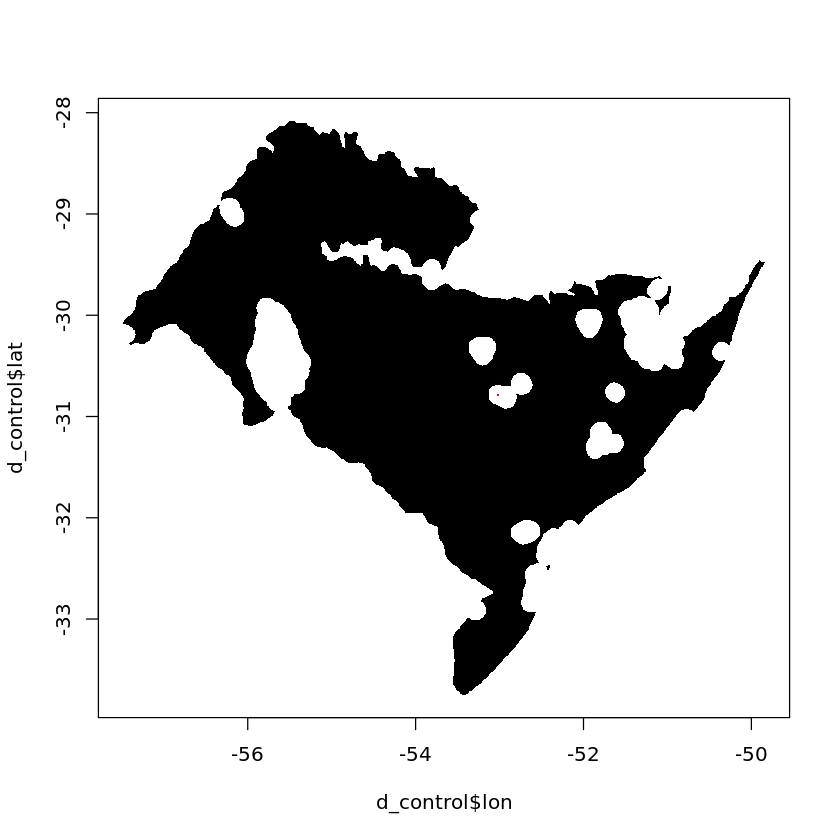

In [29]:
plot(d_control$lon, d_control$lat, pch=".")
points(d_pa$lon, d_pa$lat, pch=".", col="red")